# Face-based Depression Detection Model

In [1]:

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from models.face_strnn import FaceSTRNN
from preprocessing.loader_face import FaceLoader
from preprocessing.loader_results import ResultsLoader
from training.trainer_face_strnn import FaceSTRNNTrainer

# Constants
RANDOM_STATE = 42
DATA_PERCENTAGE = 0.02  # Percentage of total data to use
BATCH_SIZE = 32
N_EPOCHS = 50
FIGURE_SIZE = (15, 8)

# Hyperparameter grid for model tuning
PARAM_GRID = {
    'hidden_size': [64, 128, 256],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0001],
    'weight_decay': [0.0001, 0.00001]
}

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


## Data Preparation

In [2]:
def load_data(percentage: float = DATA_PERCENTAGE, random_state: int = RANDOM_STATE) -> Tuple[
    pd.DataFrame, pd.DataFrame]:
    #Load and prepare the facial features data and depression labels.
    # Initialize loaders
    results_loader = ResultsLoader()
    face_loader = FaceLoader()

    # Load data
    df_result = results_loader.get_data(percentage=percentage, random_state=random_state)
    df_face = face_loader.get_data(
        percentage=percentage,
        random_state=random_state,
        ds_freq="10s",
        rw_size="10s"
    )

    return df_face, df_result


# Load the data
df_face, df_result = load_data()

# Display data overview
print("Facial Features:")
display(df_face.head())
print("\nDepression Labels:")
display(df_result.head())

Facial Features:


CLNFgaze_frame  CLNFgaze_confidence  CLNFgaze_success  \
ID  TIMESTAMP                                                                
386 0 days 00:00:00           150.5             0.843113          0.823333   
    0 days 00:00:10           450.5             0.862236          0.853333   
    0 days 00:00:20           750.5             0.976928          1.000000   
    0 days 00:00:30          1050.5             0.980110          1.000000   
    0 days 00:00:40          1350.5             0.981177          1.000000   

                     CLNFgaze_x_0  CLNFgaze_y_0  CLNFgaze_z_0  CLNFgaze_x_1  \
ID  TIMESTAMP                                                                 
386 0 days 00:00:00      0.020882      0.114932     -0.985159     -0.187369   
    0 days 00:00:10      0.060876      0.158891     -0.979911     -0.185456   
    0 days 00:00:20      0.048942      0.159756     -0.984069     -0.185223   
    0 days 00:00:30      0.051738      0.165190     -0.983668     -0.174363   
    0 days 00:00:40      0.049782      0.190049     -0.979635     -0.177583   

                     CLNFgaze_y_1  CLNFgaze_z_1  CLNFgaze_x_h0  ...  \
ID  TIMESTAMP                                                   ...   
386 0 days 00:00:00      0.090528     -0.967401       0.113978  ...   
    0 days 00:00:10      0.139311     -0.964433       0.013874  ...   
    0 days 00:00:20      0.131315     -0.971070       0.017197  ...   
    0 days 00:00:30      0.125572     -0.974557       0.018452  ...   
    0 days 00:00:40      0.144044     -0.972055       0.019017  ...   

                     CLNFfeatures3D_Z58  CLNFfeatures3D_Z59  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          519.613237          523.152257   
    0 days 00:00:10          540.856410          546.058773   
    0 days 00:00:20          519.459970          525.978237   
    0 days 00:00:30          517.561633          524.068173   
    0 days 00:00:40          520.462397          527.595803   

                     CLNFfeatures3D_Z60  CLNFfeatures3D_Z61  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          528.202373          518.264610   
    0 days 00:00:10          553.371500          541.709443   
    0 days 00:00:20          534.036180          519.386260   
    0 days 00:00:30          531.824040          517.852453   
    0 days 00:00:40          536.371060          521.483213   

                     CLNFfeatures3D_Z62  CLNFfeatures3D_Z63  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          518.100117          519.839193   
    0 days 00:00:10          540.995380          542.620157   
    0 days 00:00:20          517.987757          519.218117   
    0 days 00:00:30          516.574410          517.831330   
    0 days 00:00:40          520.167687          521.482317   

                     CLNFfeatures3D_Z64  CLNFfeatures3D_Z65  \
ID  TIMESTAMP                                                 
386 0 days 00:00:00          532.822607          520.049250   
    0 days 00:00:10          554.739960          541.980917   
    0 days 00:00:20          532.433600          519.407463   
    0 days 00:00:30          530.468837          517.485713   
    0 days 00:00:40          534.919837          520.823793   

                     CLNFfeatures3D_Z66  CLNFfeatures3D_Z67  
ID  TIMESTAMP                                                
386 0 days 00:00:00          518.517100          518.821843  
    0 days 00:00:10          540.564557          541.449437  
    0 days 00:00:20          518.413260          519.975663  
    0 days 00:00:30          516.407047          517.912367  
    0 days 00:00:40          519.626513          521.243973  

[5 rows x 4858 columns]


Depression Labels:


,PHQ_Binary
ID,
386,1
391,0


## Exploratory Data Analysis

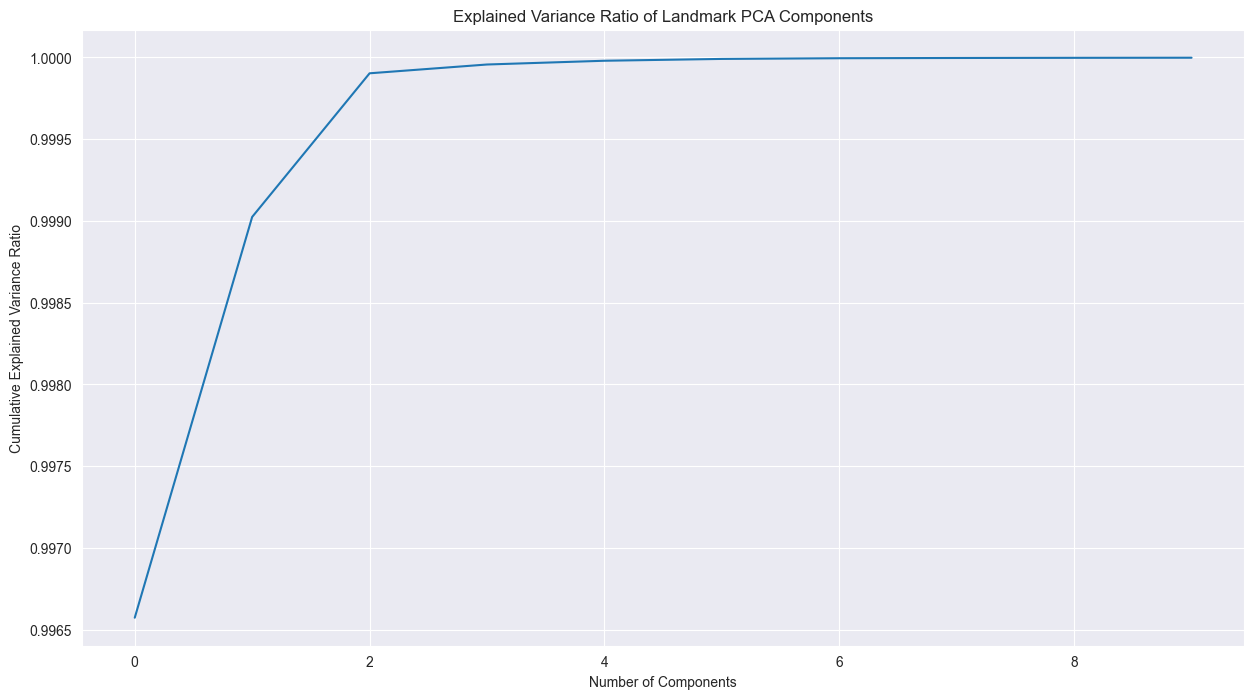

In [ ]:
def analyze_landmarks(df: pd.DataFrame) -> None:
    #Analyze facial landmarks using PCA and visualization.
    # Extract landmark features
    landmark_features = [col for col in df.columns if 'CLNFfeatures_' in col]
    landmark_data = df[landmark_features]

    # Perform PCA
    pca = PCA(n_components=10)
    landmark_pca = pca.fit_transform(landmark_data)

    # Plot explained variance ratio
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio of Landmark PCA Components')
    plt.show()

    # Plot eigenfaces -> robust to feature count
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(6):
        if i < len(pca.components_):
            comp = pca.components_[i]
            n_points = comp.shape[0] // 2
            if n_points > 0 and n_points * 2 == comp.shape[0]:
                x = comp[:n_points]
                y = comp[n_points:]
                axes[i].scatter(x, y, alpha=0.6)
                axes[i].set_xlabel('X coordinate')
                axes[i].set_ylabel('Y coordinate')
            else:
                axes[i].plot(comp, alpha=0.6)
                axes[i].set_xlabel('Feature Index')
                axes[i].set_ylabel('Component Value')
            axes[i].set_title(f'Eigenface {i + 1}')

    plt.tight_layout()
    plt.show()


def analyze_action_units(df: pd.DataFrame) -> None:
    #Analyze facial action units using visualization.
    # Extract action unit features
    au_features = [col for col in df.columns if 'CLNFAUs_' in col]

    # Create violin plots
    plt.figure(figsize=FIGURE_SIZE)
    sns.violinplot(data=df[au_features])
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Action Units')
    plt.tight_layout()
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[au_features].corr(), cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Action Units')
    plt.tight_layout()
    plt.show()


def plot_landmark_positions(df: pd.DataFrame) -> None:
    #Plot average landmark positions for each subject.
    landmark_features = [col for col in df.columns if 'CLNFfeatures_' in col]
    mean_landmarks = df.groupby('ID')[landmark_features].mean()

    x_coords = mean_landmarks[[col for col in landmark_features if '_x' in col]].values
    y_coords = mean_landmarks[[col for col in landmark_features if '_y' in col]].values

    plt.figure(figsize=(10, 10))
    plt.scatter(x_coords, y_coords, alpha=0.5)
    plt.title('Average Landmark Positions')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.axis('equal')
    plt.show()


# Perform EDA
analyze_landmarks(df_face)
analyze_action_units(df_face)
plot_landmark_positions(df_face)

## Principal Component Analysis

In [ ]:
from utils.pca_utils import save_pca_components


def perform_feature_pca(df: pd.DataFrame, n_components: int = 10):
    #Perform PCA on different facial feature types.
    # Extract different feature types
    feature_types = {
        'Gaze': [col for col in df.columns if 'CLNFgaze_' in col],
        'Action Units': [col for col in df.columns if 'CLNFAUs_' in col],
        'Pose': [col for col in df.columns if 'CLNFpose_' in col]
    }

    # Dictionary to store PCA results
    pca_results = {}

    # Perform PCA for each feature type
    for feature_name, features in feature_types.items():
        if not features:
            continue

        # Extract data and perform PCA
        feature_data = df[features]
        pca = PCA(n_components=min(n_components, len(features)))
        feature_pca = pca.fit_transform(feature_data)

        # Determine the most important features for the first principal component
        abs_loadings = np.abs(pca.components_[0])
        sorted_indices = np.argsort(abs_loadings)[::-1]
        feature_names = [features[i] for i in sorted_indices[:min(n_components, len(features))]]

        # For compatibility, return the last computed PCA's importance
        feature_importance = pd.DataFrame(
            pca.components_.T,
            columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
            index=feature_data.columns
        )

        # Store results
        pca_results[feature_name] = {
            'pca': pca,
            'feature_pca': feature_pca,
            'feature_names': feature_names,
            'feature_importance': feature_importance
        }

        # Save PCA components
        save_pca_components(
            pca=pca,
            feature_names=feature_names,
            output_path=f'models/pca_face_{feature_name.lower().replace(" ", "_")}.pkl'
        )

    # Create combined PCA features DataFrame
    pca_df = pd.DataFrame(index=df.index)
    for feature_name, result in pca_results.items():
        pca_df[result['feature_names']] = result['feature_pca']

    return pca_df, pca_results


# Perform PCA
pca_df, pca_results = perform_feature_pca(df_face)

# Plot graphs
for feature_name, result in pca_results.items():
    pca = result['pca']
    # feature_pca = result['feature_pca'] # is this ok?
    feature_importance = result['feature_importance']

    # Plot explained variance ratio
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'Explained Variance Ratio of {feature_name} PCA Components')
    plt.grid(True)
    plt.show()

    # Print variance explained
    print(f"\n{feature_name} - Explained variance ratio by component:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i + 1}: {ratio:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.heatmap(feature_importance, cmap='coolwarm', center=0)
    plt.title(f'Feature Importance in {feature_name} Principal Components')
    plt.tight_layout()
    plt.show()



## Data Splitting

In [ ]:
def prepare_data_splits(df_face: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    #Prepare data splits for training, validation, and testing.
    # Merge facial features with depression labels
    df = pd.merge(df_face, df_result, on='ID')

    # Prepare features and target
    X = df.drop(['PHQ_Binary'], axis=1)
    y = df['PHQ_Binary']

    # Create time series split
    tscv = TimeSeriesSplit(n_splits=5)
    train_indices = []
    test_indices = []

    # Get split indices while preserving temporal order
    for train_idx, test_idx in tscv.split(X):
        train_indices.append(train_idx)
        test_indices.append(test_idx)

    # Use the last fold for final train/test split
    X_train = X.iloc[train_indices[-1]]
    X_test = X.iloc[test_indices[-1]]
    y_train = y.iloc[train_indices[-1]]
    y_test = y.iloc[test_indices[-1]]

    # Further split training data into train and validation
    train_size = int(0.75 * len(X_train))
    X_train, X_val = X_train.iloc[:train_size], X_train.iloc[train_size:]
    y_train, y_val = y_train.iloc[:train_size], y_train.iloc[train_size:]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


# Prepare data splits
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data_splits(pca_df, df_result)

## Model Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau




def create_data_loaders(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray,
                        y_train: np.ndarray, y_val: np.ndarray, y_test: np.ndarray,
                        batch_size: int = BATCH_SIZE) -> Tuple[DataLoader, DataLoader, DataLoader]:
    #Create PyTorch DataLoaders for training, validation, and testing.
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Ensure input is 3D for LSTM: [batch, seq_len, input_size]
    if X_train_tensor.dim() == 2:
        X_train_tensor = X_train_tensor.unsqueeze(1)
    if X_val_tensor.dim() == 2:
        X_val_tensor = X_val_tensor.unsqueeze(1)
    if X_test_tensor.dim() == 2:
        X_test_tensor = X_test_tensor.unsqueeze(1)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader




def train_model_with_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                                 param_grid: Dict, n_epochs: int = N_EPOCHS) -> Tuple[Dict, List[Dict]]:
    #Perform grid search to find optimal hyperparameters.
    # Create data loaders
    train_loader, val_loader, _ = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

    # Initialize tracking variables
    best_val_loss = float('inf')
    best_params = None
    results = []

    # Grid search
    for params in tqdm(ParameterGrid(param_grid)):
        # Model initialization
        model = FaceSTRNN(
            input_size=X_train.shape[1],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            num_classes=2,
            dropout=params['dropout']
        ).to(DEVICE)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            verbose=True
        )

        # Initialize trainer 
        trainer = FaceSTRNNTrainer(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE
        )

        # Train model 
        train_losses, val_losses = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs
        )

        # Record results
        final_val_loss = val_losses[-1]
        results.append({
            'params': params,
            'final_val_loss': final_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

        # Update best parameters
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params

    return best_params, results




# Train model with grid search
best_params, results = train_model_with_grid_search(X_train, y_train, X_val, y_val, PARAM_GRID)

# Print best parameters
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
# print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training curves for best model
plt.figure(figsize=FIGURE_SIZE)
best_result = min(results, key=lambda x: x['final_val_loss'])
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    #Evaluate the model on the test set.
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs, _, _ = model(X)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


# Create test loader
_, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# Initialize best model
best_model = FaceSTRNN(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    num_classes=2,
    dropout=best_params['dropout']
).to(DEVICE)

# Evaluate model
y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=FIGURE_SIZE)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [ ]:
# Save the model and scaler
from training.trainer import save_model

save_model(best_model, scaler, X_train.shape[1], best_params, "face_model.pth")
print("Model and scaler saved successfully!")